# Part 3 - Gradient Descent for Matrix Factorization

The notebook in [Part 2]() introduced the Alternating Least Squares (*ALS*) algorithm for matrix factorization. Using that algorithm, it was possible to build a recommendation system without utilizing any feature engineering or additional metadata. This notebook will introduce an alternative algorithm that achieves the same goal, but training via gradient descent. 

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import PIL
import random
import sklearn
import sklearn.metrics
import scipy
import IPython.display

random.seed(42)
np.random.seed(42)

Load the train and test datasets created in the dataset exploration notebook.

In [2]:
train_ratings = scipy.sparse.load_npz('datasets/train.dat.npz').toarray()
test_ratings = scipy.sparse.load_npz('datasets/test.dat.npz').toarray()

num_users = train_ratings.shape[0]
num_items = train_ratings.shape[1]

print('There are {0} users and {1} items.'.format(num_users, num_items))

There are 50691 users and 150 items.


The gradient descent method of optimization shares many similarities with the ALS algorithm. In particular, the following assumptions still hold:

* Each user can be represented by a small number of numerical attributes, called "latent features," or collectively, a "latent vector.
* Each item can also be represented by a small number of latent features.
* The user-item interaction can be modeled by a dot product of the user features and the item features.

However, we extend the model with a few additional observations:
* Some users tend to rate all items higher than other users. This can be captured by a latent variable that applies to all predictions from a particular user.
* Some items are objectively better than others. Thus, it would be expected that they'd have a higher rating. This can be captured by a latent variable that applies to all predictions involving a particular item.
* The ratings are not normalized. Thus, we can include a bias term over all ratings. 

Given these changes, the loss function looks a little bit different than before:

![gd_prediction_rule](images/3/gd_prediction_rule.png)

The first term, B, represents the global bias. This is a constant that can be computed before training - it is simply the average rating of an item. The next two terms represent the user and item biases, respectively. The final term is the familiar term for user-item interaction. The loss function that is minimized is looks similar to before, but has a few additional regularization terms:

![gd_loss_function_rule](images/3/gd_loss_function_rule.png)

To optimize this loss function, the standard backpropagation rules will be used. At each iteration, the gradient of the loss function for each variable will be computed, and a small step will be taken in the direction of descent. Here, eta represents the learning rate, which controls how large of a step is taken. This is a tunable parameter for the model. V represents one of the variables we are trying to optimize - that is, one of the user biases, item biases, user features, or item features.

![gd_step_rule](images/3/gd_step_rule.png)

The computation of the partial derivatives is straightforward, but tedious. When the computation is simplified, the result is the following update rules:

![gd_update_rules](images/3/gd_update_rules.png)

Here, the symbol e is introduced to represent the prediction error. That is, the difference between the user rating and the predicted rating. 

Enough talk, time to code! Fortunately, turning these mathematical expressions into executable code is straightforward. The code for performing the gradient updates are shown below. 

In [13]:
def gd_step(user_vec, item_vec, user_bias, item_bias, global_bias, ratings, nonzero_indexes, training_parameters):
    user_bias_regularization = training_parameters['user_bias_regularization']
    item_bias_regularization = training_parameters['item_bias_regularization']
    user_vec_regularization = training_parameters['user_vec_regularization']
    item_vec_regularization = training_parameters['item_vec_regularization']
    learning_rate = training_parameters['learning_rate']
    
    for nonzero_index in range(0, len(nonzero_indexes[0]), 1):
        user_idx = nonzero_indexes[0][nonzero_index]
        item_idx = nonzero_indexes[1][nonzero_index]
        prediction = predict_one(user_vec, item_vec, user_bias, item_bias, global_bias, user_idx, item_idx)
        error = ratings[user_idx, item_idx] - prediction
        
        user_bias[user_idx] += learning_rate * (error - (user_bias_regularization * user_bias[user_idx]))
        item_bias[item_idx] += learning_rate * (error - (item_bias_regularization * item_bias[item_idx]))
        user_vec[user_idx, :] += learning_rate * \
                                    (error * item_vec[item_idx, :]) - \
                                    (user_vec_regularization * user_vec[user_idx, :])
        item_vec[item_idx, :] += learning_rate * \
                                    (error * user_vec[user_idx, :]) - \
                                    (item_vec_regularization * item_vec[item_idx, :])
        
    return (user_vec, item_vec, user_bias, item_bias)

The prediction routines are similar to the prediction routines used by ALS. The only difference is that the bias terms need to be taken into account. 

In [14]:
def predict_one(user_vec, item_vec, user_bias, item_bias, global_bias, user_idx, item_idx):
    return user_vec[user_idx, :].dot(item_vec[item_idx, :]) \
            + user_bias[user_idx]\
            + item_bias[item_idx]\
            + global_bias
    
def predict_all(user_vec, item_vec, user_bias, item_bias, global_bias):
    predictions = np.zeros((num_users, num_items))
    
    for u in range(0, num_users, 1):
        for b in range(0, num_items, 1):
            predictions[u, b] = predict_one(user_vec, item_vec, user_bias, item_bias, global_bias, u, b) 
    
    return predictions

Like in the previous notebook, the mean absolute error will be the performance metric that will be tracked. Again, care must be taken to ensure that only the labeled data points participate in the error calculation.

In [ ]:
def compute_mae(predicted, actual):
    labeled_elements = actual.nonzero()
    predicted = predicted[labeled_elements].flatten()
    actual = actual[labeled_elements].flatten()
    return sklearn.metrics.mean_absolute_error(actual, predicted)

With all of the boilerplate out of the way, the training loop can be written. Here, the number of latent factors, regularization parameters, number of iterations, and initialization of the user and item features and biases are set arbitrarily. Try changing them and seeing what effect this has on the algorithm!

Note that for larger datasets or higher number of iterations, this cell may take a long time to run. 

In [15]:
num_factors = 40
num_iterations = 50

train_parameters = {}
train_parameters['user_bias_regularization'] = 0.001
train_parameters['item_bias_regularization'] = 0.001
train_parameters['user_vec_regularization'] = 0.001
train_parameters['item_vec_regularization'] = 0.001
train_parameters['learning_rate'] = 0.001

user_vectors = np.random.normal(size=(num_users, num_factors), scale=1.0 / num_factors)
item_vectors = np.random.normal(size=(num_items, num_factors), scale=1.0 / num_factors)
user_bias = np.zeros(num_users)
item_bias = np.zeros(num_items)

nonzero_indexes = train_ratings.nonzero()

global_bias = np.mean(train_ratings[np.where(train_ratings != 0)])

history = []
for train_idx in range(0, num_iterations, 1):
    old_user_vectors = user_vectors.copy()
    old_item_vectors = item_vectors.copy()
    old_user_biases = user_bias.copy()
    old_item_biases = item_bias.copy()
    user_vectors, item_vectors, user_bias, item_bias = \
        gd_step(user_vectors, item_vectors, user_bias, item_bias, global_bias, train_ratings, nonzero_indexes, train_parameters)
    
    this_history = {}
    all_predictions = predict_all(user_vectors, item_vectors, user_bias, item_bias, global_bias)
    this_history['train_mse'] = compute_mae(all_predictions, train_ratings)
    this_history['test_mse'] = compute_mae(all_predictions, test_ratings)
    this_history['diff_user_vec'] = np.sum(np.sum(np.abs(old_user_vectors - user_vectors)))
    this_history['diff_item_vec'] = np.sum(np.sum(np.abs(old_item_vectors - item_vectors)))
    this_history['diff_user_bias'] = np.sum(np.abs(old_user_biases - user_bias))
    this_history['diff_item_bias'] = np.sum(np.abs(old_item_biases - item_bias))
    
    history.append(this_history)

    IPython.display.clear_output()
    print('Completed training iteration {0} / {1} ({2:.2f}%)'.format(train_idx + 1, num_iterations, (train_idx + 1) * 100.0 / num_iterations))

print('Done!')

Completed training iteration 50 / 50 (100.00%)
Done!


Now that training is complete, the error can be plotted. Some interesting trends can be observed:

* The model takes more iterations to converge than ALS.
* The model tends to overfit as more iterations are performed. This means that care must be taken to stop training once the validation accuracy stops increasing.
* The performance is quite good, considering that zero metadata has been injected into the model. Also, there has been no attempt to do any sort of data cleaning or bias compensation. This model outperforms the ALS algorithm on this dataset.

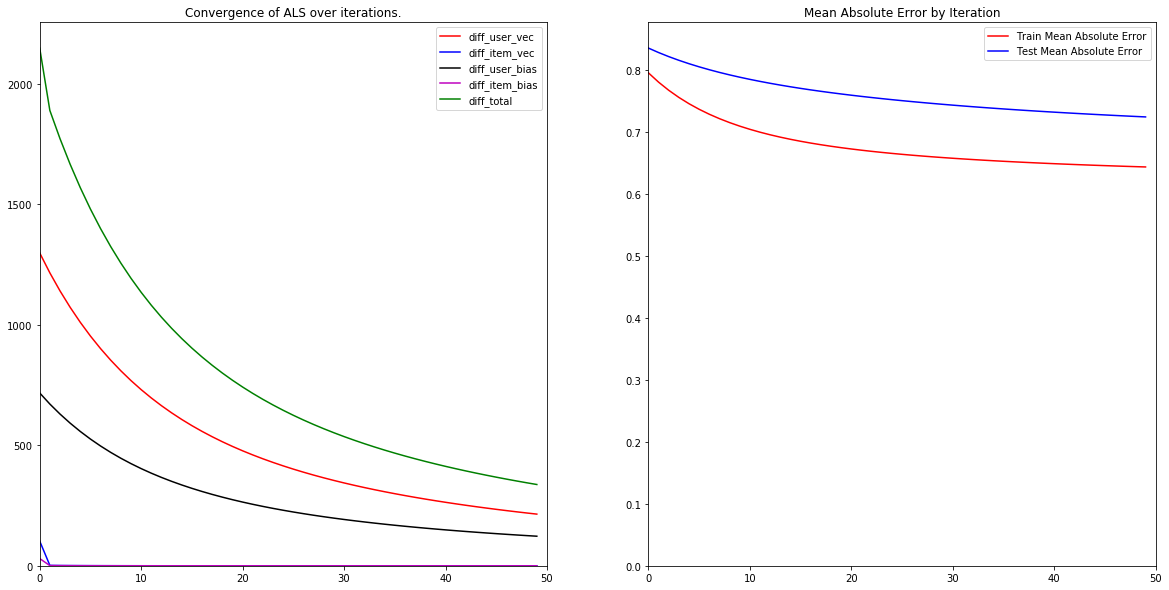

In [17]:
diff_user_vec = [h['diff_user_vec'] for h in history]
diff_items_vec = [h['diff_item_vec'] for h in history]
diff_user_bias_vec = [h['diff_user_bias'] for h in history]
diff_item_bias_vec = [h['diff_item_bias'] for h in history]
diff_total_vec = [h['diff_user_vec'] + h['diff_item_vec'] + h['diff_user_bias'] + h['diff_item_bias'] for h in history]
train_mse_vec = [h['train_mse'] for h in history]
test_mse_vec = [h['test_mse'] for h in history]
x_axis = list(range(0, len(history), 1))

fig, (ax_left, ax_right) = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

ax_left.plot(x_axis, diff_user_vec, 'r-', label='diff_user_vec')
ax_left.plot(x_axis, diff_items_vec, 'b-', label='diff_item_vec')
ax_left.plot(x_axis, diff_user_bias_vec, 'k-', label='diff_user_bias')
ax_left.plot(x_axis, diff_item_bias_vec, 'm-', label='diff_item_bias')
ax_left.plot(x_axis, diff_total_vec, 'g-', label='diff_total')
ax_left.set_title('Convergence of ALS over iterations.')
ax_left.set_xlim(0, max(x_axis) + 1)
ax_left.set_ylim(0, max(diff_total_vec) * 1.05)
ax_left.legend()

ax_right.plot(x_axis, train_mse_vec, 'r-', label='Train Mean Absolute Error')
ax_right.plot(x_axis, test_mse_vec, 'b-', label='Test Mean Absolute Error')
ax_right.set_title('Mean Absolute Error by Iteration')
ax_right.set_xlim(0, max(x_axis) + 1)
ax_right.set_ylim(0, max(test_mse_vec) * 1.05)
ax_right.legend()

plt.show()

# TODO: user prediction